In [1]:
import pandas as pd
import numpy as np
#import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric, KDTree, BallTree
import pdb

In [2]:
%matplotlib inline
np.seterr(divide='raise',invalid='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
cd Geolife\ Trajectories\ 1.3

/home/me/Documents/cse523/Geolife Trajectories 1.3


In [4]:
track = pd.read_csv('Data/000/Trajectory/20081103232153.plt', skiprows=6, header=None)

In [5]:
track.head()

,0,1,2,3,4,5,6
0,39.996948,116.325747,0,492,39755.973530,2008-11-03,23:21:53
1,39.996849,116.325763,0,491,39755.973588,2008-11-03,23:21:58
2,39.994409,116.326968,0,23,39755.973646,2008-11-03,23:22:03
3,39.995076,116.326629,0,70,39755.973704,2008-11-03,23:22:08
4,39.995193,116.326572,0,75,39755.973762,2008-11-03,23:22:13


In [6]:
track.shape

(2231, 7)

In [7]:
## distance functions
def point2dist(point, line):
    linelen = np.linalg.norm(line[1]-line[0])
    if linelen==0:
        return 0
    else:
        return np.linalg.norm(np.cross(point-line[0], line[1]-line[0]))/linelen

def vertical_distance(x, y):
    if np.linalg.norm(x[1]-x[0]) < np.linalg.norm(y[1]-y[0]):
        dist_end1 = point2dist(x[0], y)
        dist_end2 = point2dist(x[1], y)
    else:
        dist_end1 = point2dist(y[0], x)
        dist_end2 = point2dist(y[1], x)
    dist = dist_end1+dist_end2
    if dist == 0:
        return 0
    else:
        return (dist_end1**2 + dist_end2**2)/dist

def parallel_distance(x, y):
    l2square = np.dot(y[1]-y[0], y[1]-y[0])
    if l2square != 0:
        l1 = np.linalg.norm(np.dot(x[0]-y[0], y[1]-y[0])/l2square*(y[1]-y[0]))
        l2 = np.linalg.norm(y[1] - y[0] - np.dot(x[1]-y[0], y[1]-y[0])/l2square*(y[1]-y[0]))
        return min(l1, l2)
    else:
        return 0

def angular_distance(x, y):
    ylen = np.linalg.norm(y[1]-y[0])
    xlen = np.linalg.norm(x[1]-x[0])
    shorter_len = min(xlen, ylen)
    longer_len = max(xlen, ylen)
    dist = np.dot(x[1]-x[0], y[1]-y[0])
    if dist < 0:
        return shorter_len
    else:
        return 0 if longer_len==0 else np.abs(np.cross(x[1]-x[0], y[1]-y[0]))/longer_len
    
def line_distance(x, y):
    return vertical_distance(x, y)+parallel_distance(x, y)+angular_distance(x, y)


In [8]:
# MDL cost
def mdl(data, model_indexes):
    """
    calculate mdl cost
    data the raw data
    model_indexes indexes into the raw data, data points choose by indexes are used to represent the raw data
    """
    # L(H) model cost could have multiple segments
    lh = 0
    for i in range(len(model_indexes)-1):
        dist = np.linalg.norm(data[model_indexes[i]]-data[model_indexes[i+1]])
        lh = lh + np.log2(dist) if dist!=0 else 0
    # L(D|H)
    ldh = 0
    # the index into the model_indexes, NOT into raw data
    model_index = 0
    for i in range(len(data)-1):
        if i > model_indexes[model_index+1]:
            model_index = model_index + 1

        model_i_start = model_indexes[model_index]
        model_i_end = model_indexes[model_index+1]
        
        if i!=model_i_start or i+1!=model_i_end:
            dist = vertical_distance((data[model_i_start], data[model_i_end]),(data[i], data[i+1]))* \
                angular_distance((data[model_i_start], data[model_i_end]), (data[i], data[i+1]))
            ldh = ldh + np.log2(dist) if dist!=0 else 0
    return lh + ldh

In [9]:
## MDL partition algorithm
def mdl_partition(path):
    partition_set = [path[0]]
    start_index = 0
    length = 1
    while start_index + length < len(path):
        curr_index = start_index + length
        # MDL cost if curr_index is included as a characteristic point
        mdlparcost=mdl(path[start_index:curr_index+1], (0, curr_index-start_index))
        # no partition, segmented line
        mdlnoparcost=mdl(path[start_index:curr_index+1], np.arange(curr_index-start_index+1))
        if mdlparcost > mdlnoparcost:
            partition_set = partition_set + [path[curr_index-1]]
            start_index = curr_index-1
            length = 1
        else:
            length = length + 1
    partition_set = partition_set + [path[len(path)-1]]
    return partition_set

In [10]:
partitions=(np.array(mdl_partition(track[[0,1]].values)))

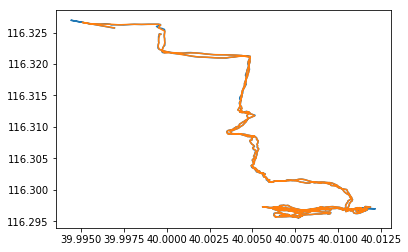

In [11]:
plt.plot(track[0], track[1])

plt.plot(partitions[:, 0], partitions[:, 1])

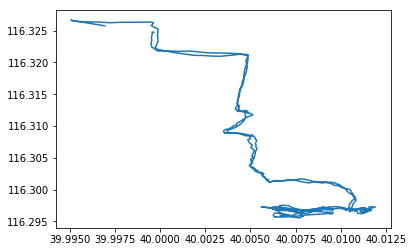

In [12]:
plt.plot(partitions[:, 0], partitions[:, 1])

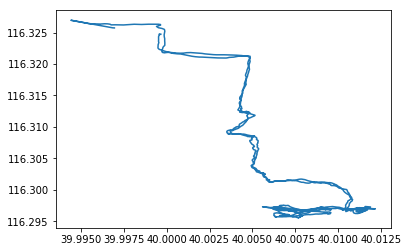

In [13]:
plt.plot(track[0], track[1])

In [14]:
partitions.shape

(713, 2)

In [15]:
segment_dist=np.zeros(len(partitions)-1)
for i in np.arange(len(partitions)-1):
    segment_dist[i] = np.linalg.norm(partitions[i] - partitions[i+1])

In [16]:
np.histogram(segment_dist)

(array([463, 182,  37,  20,   9,   0,   0,   0,   0,   1]),
 array([  1.41421356e-06,   2.08210174e-04,   4.15006135e-04,
          6.21802095e-04,   8.28598055e-04,   1.03539402e-03,
          1.24218998e-03,   1.44898594e-03,   1.65578190e-03,
          1.86257786e-03,   2.06937382e-03]))

(array([  74.,  121.,   92.,   82.,   94.,   70.,   60.,   27.,   17.,
           8.,   11.,    7.,    6.,    7.,    6.,    4.,    8.,    3.,
           0.,    5.,    3.,    2.,    2.,    2.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([  1.41421356e-06,   4.27734057e-05,   8.41325977e-05,
          1.25491790e-04,   1.66850982e-04,   2.08210174e-04,
          2.49569366e-04,   2.90928558e-04,   3.32287750e-04,
          3.73646942e-04,   4.15006135e-04,   4.56365327e-04,
          4.97724519e-04,   5.39083711e-04,   5.80442903e-04,
          6.21802095e-04,   6.63161287e-04,   7.04520479e-04,
          7.45879671e-04,   7.87238863e-04,   8.28598055e-04,
          8.69957248e-04,   9.11316440e-04,   9.52675632e-04,
          9.94034824e-04,   1.03539402e-03,   1.07675321e-03,
          1.11811240e-03,   1.15947159e-03

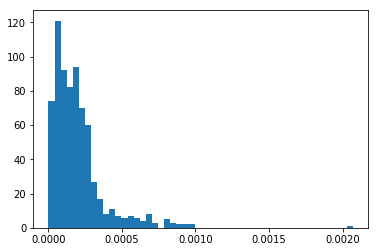

In [17]:
plt.hist(segment_dist, bins=50)

In [18]:
def segment_clustering(segments, eps, minlines):
    """
    cluster line segment
    segments: line segments to be clustered
    eps: eps-neighbour
    minlines: threshold, mimimum number of lines
    """

In [19]:
NUM_INDEX = 2
indexed_segment = np.hstack((partitions[:-1], partitions[1:], -np.ones((len(partitions)-1, NUM_INDEX))))

In [20]:
def segment_line_dist(xl, yl):
    #pdb.set_trace()
    xl = xl[:-NUM_INDEX]
    yl = yl[:-NUM_INDEX]
    dimension = len(xl)/2
    return line_distance((xl[:dimension], xl[dimension:]), (yl[:dimension], yl[dimension:]))

In [21]:
segment_line_dist(indexed_segment[0],indexed_segment[1]), segment_line_dist(indexed_segment[1],indexed_segment[0])

(0.00089589218101863001, 0.00089547277311731162)

In [22]:
indexed_segment[:10]

array([[  39.996948,  116.325747,   39.995076,  116.326629,   -1.      ,
          -1.      ],
       [  39.995076,  116.326629,   39.995464,  116.326425,   -1.      ,
          -1.      ],
       [  39.995464,  116.326425,   39.996123,  116.326359,   -1.      ,
          -1.      ],
       [  39.996123,  116.326359,   39.996692,  116.326337,   -1.      ,
          -1.      ],
       [  39.996692,  116.326337,   39.997222,  116.326237,   -1.      ,
          -1.      ],
       [  39.997222,  116.326237,   39.997912,  116.326315,   -1.      ,
          -1.      ],
       [  39.997912,  116.326315,   39.99831 ,  116.326313,   -1.      ,
          -1.      ],
       [  39.99831 ,  116.326313,   39.998733,  116.326314,   -1.      ,
          -1.      ],
       [  39.998733,  116.326314,   39.999521,  116.326333,   -1.      ,
          -1.      ],
       [  39.999521,  116.326333,   39.999646,  116.326202,   -1.      ,
          -1.      ]])

In [65]:
tree = BallTree(indexed_segment,leaf_size=10,  metric=segment_line_dist)

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [59]:
segment_line_dist.__class__.__name__

'function'

In [23]:
DistanceMetric.get_metric(segment_line_dist)

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [67]:
%debug

> /usr/lib/python2.7/dist-packages/numpy/core/numeric.py(1769)cross()
   1767            "(dimension must be 2 or 3)")
   1768     if a.shape[-1] not in (2, 3) or b.shape[-1] not in (2, 3):
-> 1769         raise ValueError(msg)
   1770 
   1771     # Create the output array

ipdb> u
> <ipython-input-48-b52d50629380>(7)point2dist()
      5         return 0
      6     else:
----> 7         return np.linalg.norm(np.cross(point-line[0], line[1]-line[0]))/linelen
      8 
      9 def vertical_distance(x, y):

ipdb> u
> <ipython-input-48-b52d50629380>(14)vertical_distance()
     12         dist_end2 = point2dist(x[1], y)
     13     else:
---> 14         dist_end1 = point2dist(y[0], x)
     15         dist_end2 = point2dist(y[1], x)
     16     dist = dist_end1+dist_end2

ipdb> u
> <ipython-input-48-b52d50629380>(43)line_distance()
     39     else:
     40         return 0 if longer_len==0 else np.abs(np.cross(x[1]-x[0], y[1]-y[0]))/longer_len
     41 
     42 def line_distance(x, y):
--->

In [62]:
x

,0,1,2,3,4,5,6
0,39.996948,116.325747,0,492,39755.973530,2008-11-03,23:21:53
1,39.996849,116.325763,0,491,39755.973588,2008-11-03,23:21:58
2,39.994409,116.326968,0,23,39755.973646,2008-11-03,23:22:03
3,39.995076,116.326629,0,70,39755.973704,2008-11-03,23:22:08
4,39.995193,116.326572,0,75,39755.973762,2008-11-03,23:22:13
5,39.995358,116.326480,0,94,39755.973819,2008-11-03,23:22:18
6,39.995464,116.326425,0,110,39755.973877,2008-11-03,23:22:23
7,39.995647,116.326402,0,133,39755.973935,2008-11-03,23:22:28
8,39.995868,116.326379,0,158,39755.973993,2008-11-03,23:22:33
9,39.996123,116.326359,0,186,39755.974051,2008-11-03,23:22:38
